In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [414]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
test_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_test.csv', parse_dates=[['Month', 'Year']])
test_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_test.csv')
test_APIs = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Test_APIs.csv')
test_APIs.shape, harmony_data.shape, IHS_data.shape, test_data.shape, test_data.shape,

((1134, 1), (8930, 7), (9224, 14), (394074, 9), (6489, 11))

## Exploratory Data Analysis

In [415]:
harmony_data.head(3)

,API,LATERAL_LENGTH_BLEND,PROP_PER_FOOT,WATER_PER_FOOT,GOR_30,GOR_60,GOR_90
0,5123371740000,9056,1025.8680,790.7205,2300.919963,2290.231375,2171.635752
1,5123377360000,4101,NaN,NaN,3786.669639,3838.096579,4012.142621
2,5123378210000,4161,916.0801,839.9280,2399.490505,2291.864862,2472.275585


In [416]:
IHS_data.head(2)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
0,33105037530000,2014-09-10,2014-12-31,2015-05-05,2015-03-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.227596,-103.299600,48.2546,-103.29997
1,33105032020000,2013-09-09,2013-11-02,2014-04-28,2014-04-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.230954,-103.189754,48.1983,-103.19195


In [417]:
test_data.head(2)

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,2015-03-01,33053063590000,17186,26624,1.549168,8213,0.477889,16,2016-08-11 14:03:14.000
1,2015-04-01,33053063590000,18796,21796,1.159608,7255,0.385986,30,2016-08-11 14:03:14.000


In [418]:
test_data.head(2)

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate,date
0,33053052530100,2014,7,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990,2014-07-01
1,33053052530100,2014,8,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990,2014-08-01


In [419]:
test_data.set_index('date', inplace=True)
test_data.drop(['Year','Month'], axis=1, inplace=True)

In [420]:
test_data.head(2)

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2014-07-01,33053052530100,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990
2014-08-01,33053052530100,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990


In [421]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394074 entries, 0 to 394073
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Month_Year    394074 non-null  datetime64[ns]
 1   API           394074 non-null  int64         
 2   Liquid        394074 non-null  int64         
 3   Gas           394074 non-null  int64         
 4   RatioGasOil   394074 non-null  float64       
 5   Water         394074 non-null  int64         
 6   PercentWater  394074 non-null  float64       
 7   DaysOn        394074 non-null  int64         
 8   _LastUpdate   394074 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 27.1+ MB


#### Checking null values

In [422]:
# Check for missing values
test_data.isnull().sum()

Month_Year      0
API             0
Liquid          0
Gas             0
RatioGasOil     0
Water           0
PercentWater    0
DaysOn          0
_LastUpdate     0
dtype: int64

In [423]:
IHS_data.isnull().sum()

API                      0
PermitDate               0
SpudDate                 0
CompletionDate           0
FirstProductionDate    183
operatorNameIHS          0
formation                0
BasinName                0
StateName                0
CountyName               0
LatWGS84                 0
LonWGS84                 0
BottomHoleLatitude       0
BottomHoleLongitude      0
dtype: int64

In [424]:
harmony_data.isnull().sum()

API                       0
LATERAL_LENGTH_BLEND      0
PROP_PER_FOOT           460
WATER_PER_FOOT          633
GOR_30                  135
GOR_60                  135
GOR_90                  135
dtype: int64

### Compare the number of wells

In [425]:
# IHS_data Number of wells
IHS_data.API.unique().shape

(8930,)

In [426]:
# Harmony_data Number of wells
harmony_data.API.unique().shape

(8930,)

In [427]:
# test_data Number of wells
test_data.API.unique().shape[0] + test_data.API.unique().shape[0]

8973

In [428]:
# test_data Number of wells
test_data.API.unique().shape

(1129,)

In [429]:
# Get repetead wells in test and test data
repetead_wells = []
for well in test_data.API.unique():
    if well in test_data.API.unique():
        repetead_wells.append(well)

print(len(repetead_wells))

43


#### Check values of each column

In [430]:
# Compare the same WELL in test and test data
test_data[(test_data['API']) == 42301322730000][5:10]

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
393178,2016-11-01,42301322730000,2232,32100,14.381720,27628,12.378136,0,2018-07-08 10:03:10.183
393179,2016-12-01,42301322730000,2506,31466,12.556265,27082,10.806864,0,2018-07-08 10:03:10.183
393180,2017-01-01,42301322730000,2484,34719,13.977053,29882,12.029791,0,2018-07-08 10:03:10.183
393181,2017-02-01,42301322730000,2180,26156,11.998165,22512,10.326606,0,2018-07-08 10:03:10.183
393182,2017-03-01,42301322730000,2281,22903,10.040772,19712,8.641824,0,2018-11-04 10:19:16.577


In [431]:
# Compare the same WELL in test and test data
test_data[(test_data['API'] == 42301322730000)]

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2015-02-01,42301322730000,10801,36697,3.397556,31584,2.924174,0,2018-11-04 10:19:16.577
2015-03-01,42301322730000,17497,78231,4.471109,67331,3.848145,0,2018-11-04 10:19:16.577
2015-04-01,42301322730000,12283,65415,5.325653,56301,4.583652,0,2018-11-04 10:19:16.577
2015-05-01,42301322730000,9661,64795,6.706863,55767,5.772384,0,2018-11-04 10:19:16.577


In [432]:
# Check if all the wells in test data are in harmony_data and IHS_data
set(test_APIs.index.unique()) - set(harmony_data.index.unique()), set(test_APIs.index.unique()) - set(IHS_data.index.unique())

(set(), set())

In [433]:
# IHS data has more observations than harmony data and wells, it is necessary to verify data that are duplicated 
IHS_data[IHS_data.API.isin(list(IHS_data.API[IHS_data.API.duplicated()]))].head(6)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
272,42301320940000,2014-01-02,2014-02-19,2014-04-17,NaN,WPX ENERGY PRODUCTION LLC,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.942399,-103.870208,31.95571,-103.86969
281,42301322750000,2014-08-09,2015-04-08,2015-07-21,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.971822,-103.626594,31.95668,-103.62589
289,42301323710000,2014-10-10,2014-12-18,2015-05-27,2016-01-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
290,42301323710000,2014-10-10,2014-12-18,2015-05-27,2015-05-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
310,42301326020000,2015-05-21,2015-06-20,2015-08-05,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.986463,-103.619420,31.99981,-103.62003
316,42109325790000,2013-05-29,2013-08-10,2014-02-17,NaN,COG OPERATING LIMITED LIABILITY CORP,BONE SPRING,PERMIAN BASIN,TEXAS,CULBERSON,31.986781,-104.033066,31.99947,-104.03214


In [434]:
# Drop duplicated wells in IHS data
IHS_data_nd = IHS_data.drop_duplicates(subset=['API']).reset_index()
IHS_data_nd.shape

(8930, 15)

In [444]:
# Map the IHS_data to the test_data
for column in IHS_data_nd.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

for column in IHS_data_nd.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

In [445]:
# Map the harmony_data to the test_data
for column in harmony_data.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

for column in harmony_data.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

In [446]:
# Drop columns with no relevance
test_df = test_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)
test_df = test_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)

In [450]:
# Rename date column to match test_data
test_df.rename(columns={'Month_Year':'date'}, inplace=True)

In [451]:
# Set date and API as index
test_df.set_index('date', inplace=True)

In [456]:
# Check if test_df and test_df have the same columns
set(test_df.columns) - set(test_df.columns)

set()

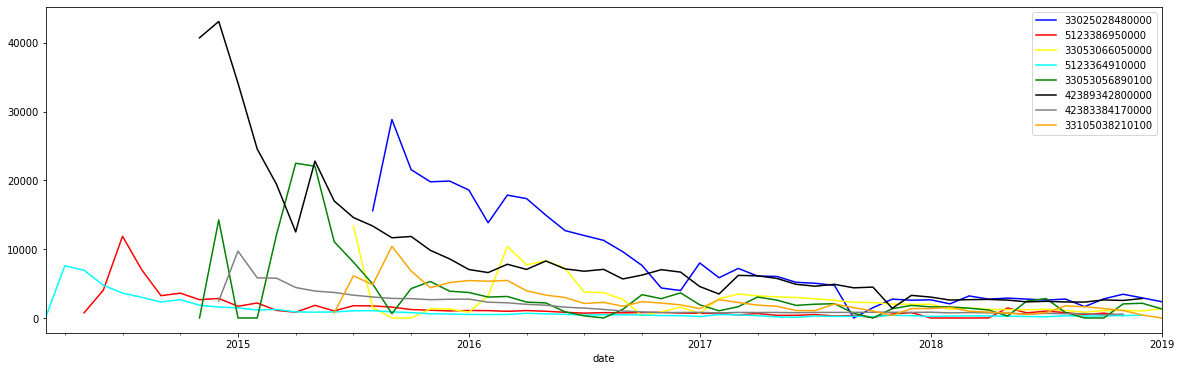

In [457]:
# Plot 10 random wells from test_df to see their behaviour
random_wells = np.random.choice(test_df.API.unique(), 8)
test_df[(test_df['API'] == random_wells[0])]['Liquid'].plot(figsize=(20, 6), color='blue')
test_df[(test_df['API'] == random_wells[1])]['Liquid'].plot(figsize=(20, 6), color='red')
test_df[(test_df['API'] == random_wells[2])]['Liquid'].plot(figsize=(20, 6), color='yellow')
test_df[(test_df['API'] == random_wells[3])]['Liquid'].plot(figsize=(20, 6), color='cyan')
test_df[(test_df['API'] == random_wells[4])]['Liquid'].plot(figsize=(20, 6), color='green')
test_df[(test_df['API'] == random_wells[5])]['Liquid'].plot(figsize=(20, 6), color='black')
test_df[(test_df['API'] == random_wells[6])]['Liquid'].plot(figsize=(20, 6), color='grey')
test_df[(test_df['API'] == random_wells[7])]['Liquid'].plot(figsize=(20, 6), color='orange')
plt.legend(random_wells)
plt.show()

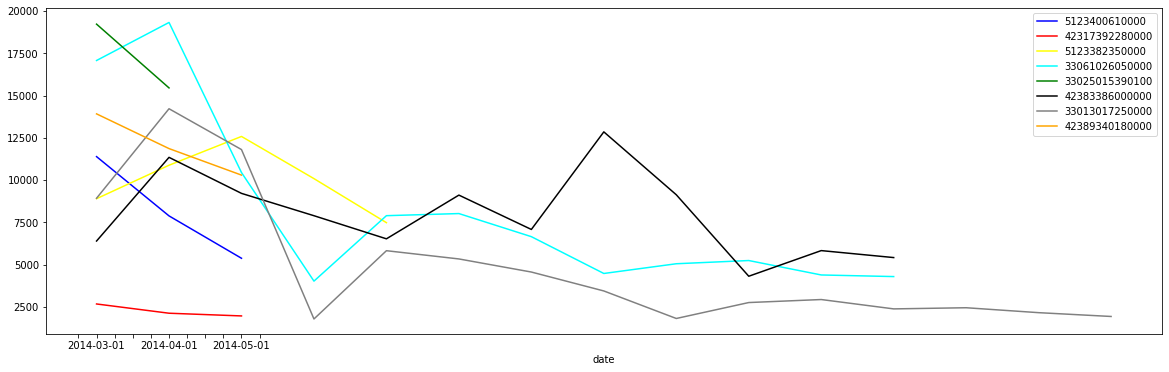

In [460]:
# Plot 10 random wells from test_df to see their behaviour
random_wells = np.random.choice(test_df.API.unique(), 8)
test_df[(test_df['API'] == random_wells[0])]['Liquid'].plot(figsize=(20, 6), color='blue')
test_df[(test_df['API'] == random_wells[1])]['Liquid'].plot(figsize=(20, 6), color='red')
test_df[(test_df['API'] == random_wells[2])]['Liquid'].plot(figsize=(20, 6), color='yellow')
test_df[(test_df['API'] == random_wells[3])]['Liquid'].plot(figsize=(20, 6), color='cyan')
test_df[(test_df['API'] == random_wells[4])]['Liquid'].plot(figsize=(20, 6), color='green')
test_df[(test_df['API'] == random_wells[5])]['Liquid'].plot(figsize=(20, 6), color='black')
test_df[(test_df['API'] == random_wells[6])]['Liquid'].plot(figsize=(20, 6), color='grey')
test_df[(test_df['API'] == random_wells[7])]['Liquid'].plot(figsize=(20, 6), color='orange')
plt.legend(random_wells)
plt.show()

In [462]:
test_df[(test_df['API'] == random_wells[6])]

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,operatorNameIHS_new,formation_new,BasinName_new,StateName_new,CountyName_new,BottomHoleLatitude_new,BottomHoleLongitude_new,LATERAL_LENGTH_BLEND_new,PROP_PER_FOOT_new,WATER_PER_FOOT_new
date,,,,,,,,,,,,,,,,,
2014-03-01,33013017250000,8929,3641,0.407772,44574,4.992048,26,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-04-01,33013017250000,14218,3641,0.256084,46520,3.271909,27,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-05-01,33013017250000,11805,7338,0.621601,43679,3.700042,30,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-06-01,33013017250000,1793,1410,0.786392,10379,5.788622,13,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-07-01,33013017250000,5828,7960,1.365820,29122,4.996911,31,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-08-01,33013017250000,5341,10102,1.891406,24974,4.675903,31,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-09-01,33013017250000,4567,7757,1.698489,21912,4.797898,30,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-10-01,33013017250000,3449,2225,0.645115,17959,5.207017,31,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505
2014-11-01,33013017250000,1822,4011,2.201427,9042,4.962678,19,CORNERSTONE NATURAL RESOURCES LLC,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,BURKE,48.77772,-102.42829,9320,548.9614,551.7505


In [442]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394074 entries, 2015-03-01 to 2018-09-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       394074 non-null  int64  
 1   Liquid                    394074 non-null  int64  
 2   Gas                       394074 non-null  int64  
 3   RatioGasOil               394074 non-null  float64
 4   Water                     394074 non-null  int64  
 5   PercentWater              394074 non-null  float64
 6   DaysOn                    394074 non-null  int64  
 7   operatorNameIHS_new       394074 non-null  object 
 8   formation_new             394074 non-null  object 
 9   BasinName_new             394074 non-null  object 
 10  StateName_new             394074 non-null  object 
 11  CountyName_new            394074 non-null  object 
 12  BottomHoleLatitude_new    394074 non-null  float64
 13  BottomHoleLongitude_new   39

In [455]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6489 entries, 2014-07-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   API                       6489 non-null   int64  
 1   Liquid                    6489 non-null   int64  
 2   Gas                       6489 non-null   int64  
 3   RatioGasOil               6489 non-null   float64
 4   Water                     6489 non-null   int64  
 5   PercentWater              6489 non-null   float64
 6   DaysOn                    6489 non-null   int64  
 7   operatorNameIHS_new       6489 non-null   object 
 8   formation_new             6489 non-null   object 
 9   BasinName_new             6489 non-null   object 
 10  StateName_new             6489 non-null   object 
 11  CountyName_new            6489 non-null   object 
 12  BottomHoleLatitude_new    6489 non-null   float64
 13  BottomHoleLongitude_new   6489 non-null   float64
 14

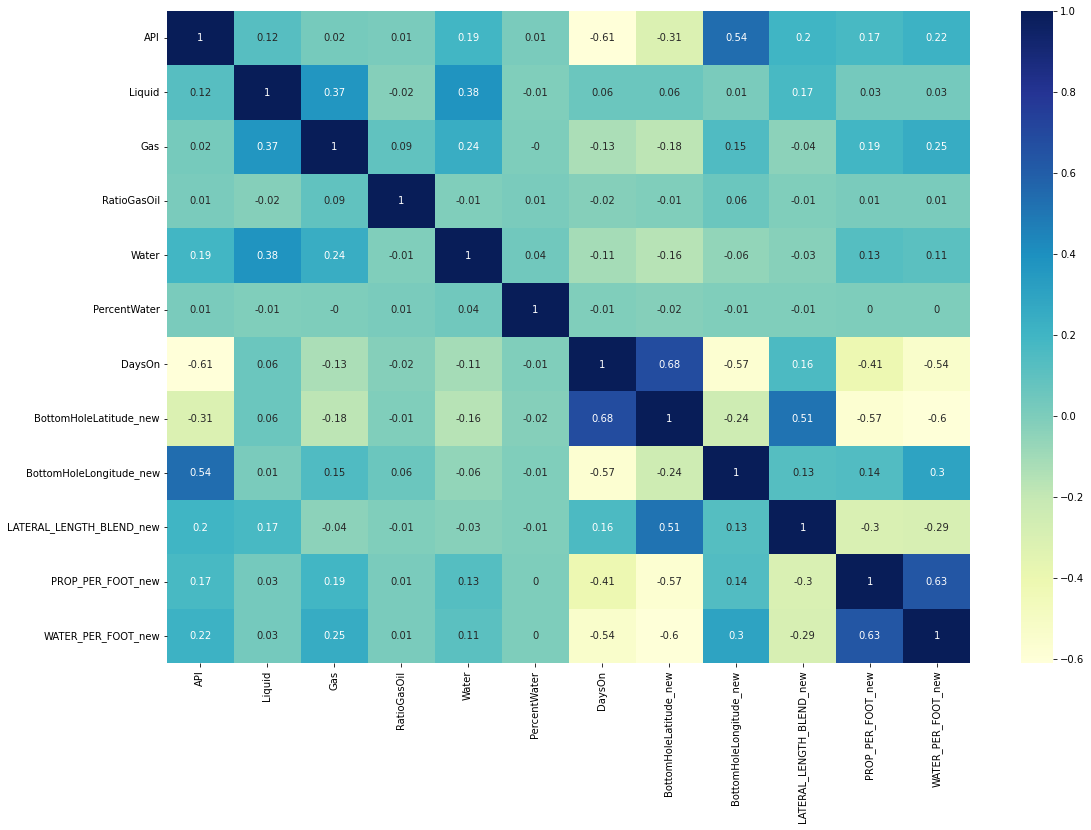

In [443]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(test_df.corr(),2), annot=True, cmap='YlGnBu');